# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [31]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import sys
from essentia import Pool, array
from essentia.standard import *
import numpy as np
import IPython

In [32]:
#compute onset detection
def compute_onsets(audio):
    '''
    Onset detection functiom using High Frequency Content detection function.
    Parameters: 
    ------------
    :audio: audio
    '''
    od1 = OnsetDetection(method='hfc')
    w = Windowing(type = 'hann')
    fft = FFT() 
    c2p = CartesianToPolar()
    pool = essentia.Pool()
    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od1(mag, phase))

    onsets = Onsets()
    onsets_hfc = onsets(essentia.array([ pool['features.hfc'] ]),[ 1 ])
    onsets_in_samples = []
    for onset in onsets_hfc:
        onsets_in_samples.append(onset*44100)  
    return onsets_in_samples

In [33]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'

def analyze_sound(audio_path, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()

    
    # Calculate the start and end samples for each audio frame according to the onset previously detected. 
    onsets_in_samples = compute_onsets(audio)    
    frame_start_samples = onsets_in_samples[:-1]
    frame_start_end_samples = onsets_in_samples[1:]
    
    # Iterate over audio frames and analyze each one
    for count in range(len(frame_start_samples)):
        fstart = int(frame_start_samples[count])
        fend = int(frame_start_end_samples[count])
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        if len(frame) % 2 == 1:
            frame = frame = audio[fstart:fend-1] # I need this to compute FFT with an even buffer size
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        #extract danceability
        danceability_algo = estd.Danceability()
        danceability = danceability_algo(frame)
        frame_output['danceability'] = danceability[0]
        
        #extract intensity
        intensity_algo = estd.Intensity()
        intensity = intensity_algo(frame)
        frame_output['intensity'] = intensity
        
        #extract_tonality 
        tonality = estd.KeyExtractor()
        key = tonality(frame)
        tonality = {
            'A': 0,
            'B': 1,
            'C': 2,
            'D': 3,
            'E': 4,
            'F': 5,
            'G': 6,
            
        }
        #mapping tonality string value to number
        frame_output['key'] = tonality[key[0][0]]
        
        
        #Peak Detection
        peack_detection_algo = estd.PeakDetection()
        peackDetection = peack_detection_algo(frame)
        #average of positiona and amplitude of peak detection 
        frame_output['peak_detection_pos_avr'] = np.average(peackDetection[0])
        frame_output['peak_detection_amp_avr'] = np.average(peackDetection[1])
        
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
    

## Analyze source collection

In [34]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], audio_id=sound['freesound_id'])  
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame




Analyzing sound with id 362156 [1/114]
Analyzing sound with id 181425 [2/114]
Analyzing sound with id 439596 [3/114]
Analyzing sound with id 203647 [4/114]
Analyzing sound with id 16054 [5/114]
Analyzing sound with id 40404 [6/114]
Analyzing sound with id 1377 [7/114]
Analyzing sound with id 186498 [8/114]
Analyzing sound with id 121776 [9/114]
Analyzing sound with id 58900 [10/114]
Analyzing sound with id 157441 [11/114]
Analyzing sound with id 336247 [12/114]
Analyzing sound with id 48254 [13/114]
Analyzing sound with id 401692 [14/114]
Analyzing sound with id 246268 [15/114]
Analyzing sound with id 410365 [16/114]
Analyzing sound with id 47031 [17/114]
Analyzing sound with id 38084 [18/114]
Analyzing sound with id 119546 [19/114]
Analyzing sound with id 380551 [20/114]
Analyzing sound with id 340861 [21/114]
Analyzing sound with id 456440 [22/114]
Analyzing sound with id 416529 [23/114]
Analyzing sound with id 424141 [24/114]
Analyzing sound with id 345687 [25/114]
Analyzing sound w

,danceability,end_sample,freesound_id,id,intensity,key,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,peak_detection_amp_avr,peak_detection_pos_avr,start_sample
0,0.000000,20992,362156,362156_f0,-1,5,0.000228,-936.800903,20.030766,-18.422951,...,4.179592,2.467964,1.354343,-4.279121,-7.994272,-11.823318,files/362156_5121236-hq.ogg,0.000657,0.054113,13311
1,0.000000,6655,181425,181425_f0,-1,1,0.001945,-888.891052,212.889618,-45.907871,...,4.429092,-9.686180,-20.458733,-16.072044,-7.119133,-26.504936,files/181425_1823830-hq.ogg,0.025780,0.233606,511
2,0.000000,8704,181425,181425_f1,-1,5,0.002491,-789.907227,209.077759,-40.128517,...,-18.570843,-8.060097,-9.724758,-8.375584,-21.814804,-22.935501,files/181425_1823830-hq.ogg,0.023070,0.472905,6655
3,0.000000,5120,203647,203647_f0,-1,4,0.000483,-784.184448,144.442993,-10.077112,...,1.283783,-9.239609,11.192844,-8.713135,-5.525467,-29.127953,files/203647_3661618-hq.ogg,0.006926,0.189688,1023
4,0.000000,6655,203647,203647_f1,-1,0,0.001557,-719.296082,168.819122,-9.768381,...,0.870544,-17.372833,4.844837,-4.432068,-22.350945,-37.683914,files/203647_3661618-hq.ogg,0.036604,0.436084,5120
5,0.000000,9215,203647,203647_f2,-1,4,0.001594,-706.950500,171.143524,3.187222,...,-8.076599,-8.560196,-0.948803,-6.414314,-20.488052,-22.557816,files/203647_3661618-hq.ogg,0.029524,0.275211,6655
6,0.000000,14848,203647,203647_f3,0,4,0.003809,-674.901611,181.707794,-11.126310,...,-17.068188,-17.840515,-1.409100,-13.462738,-29.982512,-29.001366,files/203647_3661618-hq.ogg,0.043840,0.118898,9215
7,1.006129,66048,203647,203647_f4,0,4,0.004513,-744.226257,214.656403,-26.328650,...,3.312149,-36.806606,17.690952,-6.849991,-27.568184,-24.618309,files/203647_3661618-hq.ogg,0.144083,0.017242,14848
8,0.943983,87039,203647,203647_f5,0,4,0.005900,-717.406982,216.597412,-24.563292,...,-2.423981,-12.789124,17.485035,0.181900,-21.498634,-34.422295,files/203647_3661618-hq.ogg,0.137331,0.048507,66048
9,1.382455,120832,203647,203647_f6,0,4,0.004401,-705.749390,168.492218,-26.989321,...,-9.441677,6.750622,0.375473,2.035683,-19.629524,-32.481010,files/203647_3661618-hq.ogg,0.181403,0.032475,87039


,danceability,end_sample,freesound_id,intensity,key,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,peak_detection_amp_avr,peak_detection_pos_avr,start_sample
count,780.000000,780.000000,780.000000,780.000000,780.000000,7.800000e+02,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,0.248746,144898.770513,222132.073077,-0.856410,2.735897,1.864172e-03,-914.653659,79.417167,-4.302570,-3.006677,...,15.987222,-1.822433,1.244573,-0.121900,0.618227,-4.527453,-1.240489,0.058226,0.075884,126903.908974
std,1.430580,141237.945404,152355.250142,0.379037,1.976627,2.698207e-03,129.729051,87.918052,18.340733,15.746952,...,40.321463,25.873216,27.700709,20.413650,19.474025,18.395947,16.613995,0.085562,0.090159,138212.806438
min,0.000000,4607.000000,1377.000000,-1.000000,0.000000,5.371580e-07,-1138.420044,-216.370148,-74.201492,-58.132259,...,-121.699631,-98.679214,-118.171021,-73.803223,-56.707451,-69.136719,-54.273727,-0.134734,0.001517,511.000000
25%,0.000000,46975.250000,58900.000000,-1.000000,1.000000,1.746436e-04,-1008.138870,15.490116,-14.343859,-11.898331,...,-6.603474,-13.856588,-15.617237,-10.972358,-10.795500,-15.210117,-11.127114,0.005497,0.022961,30464.000000
50%,0.000000,97535.500000,203647.000000,-1.000000,2.000000,7.996636e-04,-927.635376,73.808044,-3.305359,-2.172367,...,11.820690,0.767363,-0.306240,0.032900,0.648766,-4.020973,-0.879050,0.023053,0.045796,81151.500000
75%,0.000000,198143.000000,386358.000000,-1.000000,5.000000,2.367044e-03,-832.252914,143.568275,5.901145,6.706379,...,40.140356,13.239615,15.944767,10.118030,11.663317,5.602609,8.723202,0.072787,0.093939,176767.250000
max,36.975010,728576.000000,490111.000000,1.000000,6.000000,2.070204e-02,-482.423035,282.241608,61.875523,63.390991,...,166.041870,65.188461,104.522964,74.040443,65.467636,73.231445,83.039619,0.508904,0.682623,720383.000000


## Analyze the target sound file

Analyzing target sound 180053__drandarko__drum-loop.wav
Saved target dataframe with 220 entries! dataframe_target.csv


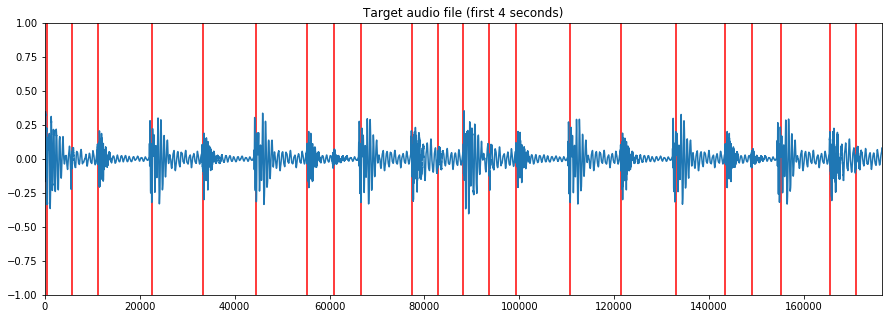

,danceability,end_sample,freesound_id,id,intensity,key,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,peak_detection_amp_avr,peak_detection_pos_avr,start_sample
0,0.0,5631,None,None_f0,-1,2,0.004092,-964.042969,183.726440,2.219784,...,51.048908,24.845398,14.828648,20.827143,14.916538,4.701141,180053__drandarko__drum-loop.wav,0.030156,0.081621,511
1,0.0,11263,None,None_f1,-1,0,0.000659,-1066.561890,97.710548,8.758343,...,54.159000,38.298767,25.721794,17.179941,12.272434,9.886583,180053__drandarko__drum-loop.wav,0.013312,0.067498,5631
2,0.0,22527,None,None_f2,-1,0,0.000670,-1020.376770,79.248268,7.972111,...,58.135944,43.778763,40.181084,34.213100,16.929508,8.949640,180053__drandarko__drum-loop.wav,0.019555,0.057621,11263
3,0.0,33279,None,None_f3,-1,2,0.001957,-1061.845581,104.167732,8.669903,...,57.247272,39.588623,25.335533,15.645411,10.418896,8.597017,180053__drandarko__drum-loop.wav,0.044028,0.475932,22527
4,0.0,44544,None,None_f4,-1,5,0.000646,-1001.460938,65.972435,11.347240,...,44.343296,47.458115,42.404503,29.382784,25.387249,8.839975,180053__drandarko__drum-loop.wav,0.044135,0.048098,33279
5,0.0,55295,None,None_f5,-1,2,0.001996,-1060.309937,106.029427,8.930172,...,56.573887,38.613342,24.551746,15.356730,10.622303,9.019350,180053__drandarko__drum-loop.wav,0.042402,0.462196,44544
6,0.0,60927,None,None_f6,-1,2,0.000599,-858.078369,80.689697,12.577724,...,29.721298,48.248398,34.784027,40.451500,24.239262,17.065716,180053__drandarko__drum-loop.wav,0.020383,0.113408,55295
7,0.0,66559,None,None_f7,-1,2,0.000896,-1043.799072,59.294003,6.485092,...,20.325726,28.906425,12.657440,7.900957,2.036827,14.341122,180053__drandarko__drum-loop.wav,0.023756,0.048503,60927
8,0.0,77312,None,None_f8,-1,2,0.002039,-1061.089600,105.132545,8.731716,...,57.274616,39.425903,25.128441,15.503107,10.380459,8.636477,180053__drandarko__drum-loop.wav,0.033547,0.388400,66559
9,0.0,82944,None,None_f9,-1,2,0.002307,-828.621948,115.640244,7.133167,...,45.553246,56.450142,36.143326,37.227051,18.655907,10.867924,180053__drandarko__drum-loop.wav,0.008890,0.114940,77312


,danceability,end_sample,intensity,key,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,peak_detection_amp_avr,peak_detection_pos_avr,start_sample
count,220.0,2.200000e+02,220.0,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,2.200000e+02
mean,0.0,8.877540e+05,-1.0,2.318182,0.001611,-996.634345,102.382494,8.068492,8.611501,4.971894,...,57.726856,47.319751,40.068683,27.835637,22.258908,14.250702,9.758783,0.030770,0.174641,8.797388e+05
std,0.0,5.104866e+05,0.0,2.108612,0.001043,84.045840,31.197475,3.691630,2.461090,4.597669,...,18.939230,14.060002,9.309948,8.879440,10.169144,6.962361,3.460933,0.016918,0.168148,5.105114e+05
min,0.0,5.631000e+03,-1.0,0.000000,0.000586,-1070.484863,46.476151,-6.974533,2.924248,-3.848970,...,22.775177,3.800774,16.430935,5.429157,2.958679,-5.769146,2.381821,-0.022927,0.035252,5.110000e+02
25%,0.0,4.450558e+05,-1.0,0.000000,0.000840,-1062.119446,81.060328,7.415089,6.742554,0.959652,...,41.076946,43.756557,38.290489,24.781700,15.606600,10.434069,7.972858,0.020011,0.049855,4.395512e+05
50%,0.0,8.849910e+05,-1.0,2.000000,0.001249,-1029.987061,102.337593,8.745029,8.869766,6.312237,...,61.397217,54.574818,40.161663,26.225822,19.325052,13.526245,8.974428,0.029448,0.089709,8.793595e+05
75%,0.0,1.324415e+06,-1.0,5.000000,0.002003,-954.509293,105.801392,9.946608,9.435371,9.127369,...,75.577240,57.298126,45.379492,34.959221,30.436037,18.999030,10.989402,0.041871,0.393177,1.319167e+06
max,0.0,1.763840e+06,-1.0,6.000000,0.004526,-807.782532,193.751312,14.724430,18.627438,11.486526,...,76.688736,59.411121,56.812515,45.411903,41.713726,27.194351,20.005194,0.076504,0.503037,1.758719e+06


In [35]:
TARGET_SOUND_PATH = '180053__drandarko__drum-loop.wav'
#TARGET_SOUND_PATH = '495684__doctor-dreamchip__2019-10-11-3.wav'

DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
#frame_size = 4410
#print(beats)
#print('duration', duration)
target_analysis = analyze_sound(TARGET_SOUND_PATH)  
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

#Audio player


# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

IPython.display.Audio(TARGET_SOUND_PATH)

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame